1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
import numpy as np
import pylab as py
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from math import pi
import pandas as pd
import math
from scipy import stats

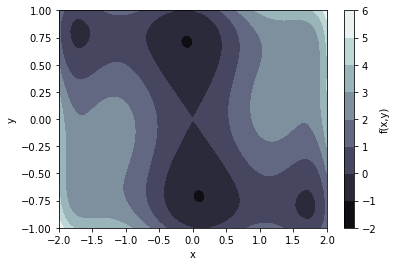

<class 'scipy.optimize.optimize.OptimizeResult'>
r_min1= [-0.08984202  0.71265641]   f(r_min1)= -1.0316284534898768
r_min2= [ 0.08984196 -0.71265649]   f(r_min2)= -1.0316284534898035


In [2]:
def f(x):
    return (4 - 2.1*x[0]**2 + (x[0]**4)/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)
X,Y = np.meshgrid(x,y)

h = f([X,Y])
                
#Trying to see minima
fig, ax = plt.subplots()
cs = plt.contourf(X,Y,h, cmap=plt.cm.bone)
cbar = fig.colorbar(cs)
plt.xlabel('x')
plt.ylabel('y')
cbar.ax.set_ylabel('f(x,y)')
plt.show()
#There are 2 candidate for global minimum

#finding the minima
min1 = minimize(f, x0 = [0.0,0.75])
min2 = minimize(f, x0 = [0.2,-0.75])

print(type(min1))
print('r_min1=', min1['x'],' ','f(r_min1)=', min1['fun'])
print('r_min2=', min2['x'],' ','f(r_min2)=', min2['fun'])

#r_min1 is the global minimum

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

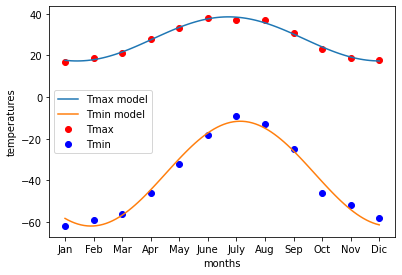

BEST PARAMETERS FOR TMAX:
amplitude: 10.58 +- 0.41
phase: 6.72 +- 0.07
omega: 0.59 +- 0.02
offset: 27.95 +- 0.43

BEST PARAMETERS FOR TMIN:
amplitude: 25.1 +- 1.3
phase: 7.13 +- 0.10
omega: 0.60 +- 0.02
offset: -36.7 +- 1.2

R2 TEST:
R2 Tmax fit: 0.9882502430477919
R2 Tmin fit: 0.9787202745547301

IS TIME OFFSET THE SAME WITHIN THE ACCURACY? False


In [3]:
T_max = np.array([17,19,21,28,33,38,37,37,31,23,19,18])
T_min = np.array([-62,-59,-56,-46,-32,-18,-9,-13,-25,-46,-52,-58])
months = np.arange(1,13,1)
xticklabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dic']
x = np.linspace(1,12,100) #line used for plotting

#I don't know the model but I will try with a cos function as some websites suggest.
def ff(x, amplitude, phase, omega, offset):
    return amplitude*np.cos(omega*(x - phase)) + offset

poM = [15,7,2*pi/12,25]
pom = [25,7,2*pi/12,-35]
poptM, pcovM = curve_fit(ff,months,T_max,poM)
poptm, pcovm = curve_fit(ff,months,T_min,pom)

fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
plt.xlabel('months')
plt.ylabel('temperatures')
ax.set_xticks(months)
ax.set_xticklabels(xticklabels)
plt.scatter(months,T_max, color = 'red', label = 'Tmax')
plt.scatter(months,T_min, color = 'blue', label = 'Tmin')
plt.plot(x,ff(x,poptM[0],poptM[1],poptM[2],poptM[3]), label = 'Tmax model')
plt.plot(x,ff(x,poptm[0],poptm[1],poptm[2],poptm[3]), label = 'Tmin model')
plt.legend(loc = 'best')
plt.show()

#I print the best parameters
print('BEST PARAMETERS FOR TMAX:')

print('amplitude: %.2f +- %.2f' %(poptM[0], np.sqrt(pcovM[0,0])))
print('phase: %.2f +- %.2f' %(poptM[1], np.sqrt(pcovM[1,1])))
print('omega: %.2f +- %.2f' %(poptM[2], np.sqrt(pcovM[2,2])))
print('offset: %.2f +- %.2f' %(poptM[3], np.sqrt(pcovM[3,3])))

print('\nBEST PARAMETERS FOR TMIN:')

print('amplitude: %.1f +- %.1f' %(poptm[0], np.sqrt(pcovm[0,0])))
print('phase: %.2f +- %.2f' %(poptm[1], np.sqrt(pcovm[1,1])))
print('omega: %.2f +- %.2f' %(poptm[2], np.sqrt(pcovm[2,2])))
print('offset: %.1f +- %.1f' %(poptm[3], np.sqrt(pcovm[3,3])))

#I try to say something on the goodness of these two fits using R^2 test
rsM = T_max - ff(months, poptM[0], poptM[1], poptM[2], poptM[3])
rsm = T_min - ff(months, poptm[0], poptm[1], poptm[2], poptm[3])
tsM = np.mean(T_max) - T_max
tsm = np.mean(T_min) - T_min

R2_M = 1 - np.sum(rsM**2)/np.sum(tsM**2)
R2_m = 1 - np.sum(rsm**2)/np.sum(tsm**2)

print('\nR2 TEST:')

print('R2 Tmax fit:', R2_M)
print('R2 Tmin fit:', R2_m)

#The used model works better for Tmax than Tmin. In both cases, the R2 values are quite close to 1, 
#so it seems to be reasonable.

print('\nIS TIME OFFSET THE SAME WITHIN THE ACCURACY?',np.abs(poptM[1] - poptm[1]) <= pcovM[1,1] + pcovm[1,1])

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

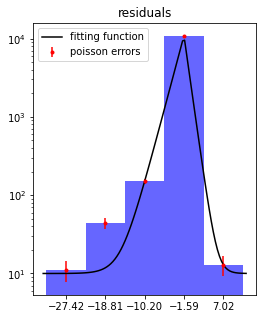

BEST PARAMETERS:
amplitude: 10886.1 +- 22.8
lambda1: 0.50 +- 0.02
lambda2: 1.0 +- 0.9

pvalue: 1.1736236165127423e-06


In [4]:
content = np.load("/Users/Luca/data/residuals_261.npy", allow_pickle = True)
df = pd.DataFrame(content.item())
del content

bins = 20 
counts, bin_edges = np.histogram(df['residuals'], bins)
bin_centres = 0.5*(bin_edges[:-1] + bin_edges[1:])
width = (max(bin_edges) - min(bin_edges))/bins

mask = counts > 10 #dropping the small counts for a better visualization of th histogram
counts = counts[mask]
bin_centres = bin_centres[mask]

err = np.sqrt(counts) #poisson errors

fig, ax = plt.subplots(figsize=(4,5))
plt.title('residuals')
plt.yscale('log') #y axis in logscale
ax.set_xticks(bin_centres)

ax.bar(bin_centres, counts, color = 'blue', width = width, alpha = 0.6)
ax.errorbar(bin_centres, counts, err, color = 'red', fmt = '.', label = 'poisson errors')
#plt.show()

#I try to fit data with this function
def f(x,amplitude, lambda1, lambda2):
     if x <= -1.59: 
            return amplitude*np.exp(lambda1*(x  +1.59)) + 10
     else:
        return amplitude*np.exp(lambda2*(- x - 1.59)) + 10
 
x = np.linspace(min(bin_centres) - 5, max(bin_centres) + 5, 100)
f = np.vectorize(f)
p0 = [1.2*1e4,0.3,0.6]
popt, pcov = curve_fit(f,bin_centres,counts,p0)
ax.plot(x,f(x,*popt), label = 'fitting function', color = 'black')
ax.legend(loc = 'best')
plt.show()

print('BEST PARAMETERS:')
print('amplitude: %.1f +- %.1f' %(popt[0], np.sqrt(pcov[0,0])))
print('lambda1: %.2f +- %.2f' %(popt[1], np.sqrt(pcov[1,1])))
print('lambda2: %.1f +- %.1f' %(popt[2], np.sqrt(pcov[2,2])))

ndof = len(bin_centres) - 1 - len(p0)
chi2 = np.sum(((counts - f(bin_centres,*popt))**2) / counts)
pvalue = 1. - stats.chi2.cdf(chi2,ndof)
print('\npvalue:', pvalue)

#The model does not fit the data at all, but the others functions I have tried to use worked even worse.

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

BEST PARAMETERS 3 PARAMETERS FIT FUNCTION:
a: 10.0 +- 0.1
b: -3.38 +- 0.01
c: 9.3 +- 0.1

AVERAGE TEMPERATURE IN MONACO: 9.25405114978069
MIN TEMPERATURE PREDICTED: -0.7432744305654246
MAX TEMPERATURE PREDICTED: 19.251089417911853

R2 FOR ff1: 0.787079020862571
R2 FOR ff2: 0.7871330020477115

TEST 3 PARAMETERS COS VS 4 PARAMETERS COS:
CL: 0.497 , additional parameter necessary: NO


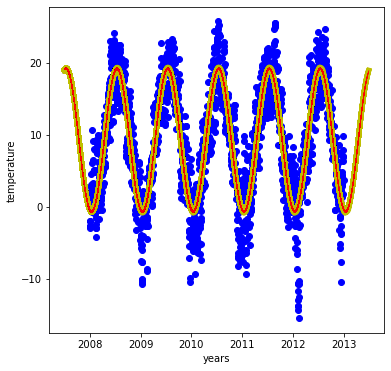

In [5]:
df = pd.read_csv('C:/Users/Luca/data/munich_temperatures_average_with_bad_data.txt', 
                 names = ['year','temperature'], sep = ' ')

df = df.sort_values(by = 'year')
df2008_2012 = df[(df.year <= 2013.) & (df.year >= 2008.) & (df.temperature < 90)] # there are 2 samples with the
#'temperature' around 100 degrees. I am assuming that they are wrong measurements.

def ff1(x,a,b,c):
    return a*np.cos(2*pi*x + b) + c

def ff2(x,a,b,c,d):
    return a*np.cos(2*pi*b*x + c) + d

p01 = [15, -pi, 5]
popt1, pcov1 = curve_fit(ff1, xdata = df2008_2012.year, ydata = df2008_2012.temperature, p0 = p01)
p02 = [15,1,-pi,5]
popt2, pcov2 = curve_fit(ff2, xdata = df2008_2012.year, ydata = df2008_2012.temperature, p0 = p02)

fig, ax = plt.subplots(figsize = (6,6))
plt.xlabel('years')
plt.ylabel('temperature')

plt.scatter(df2008_2012['year'], df2008_2012['temperature'], color = 'b' )
t = np.linspace(min(df2008_2012['year']) - 0.5, df2008_2012['year'] + 0.5, 100)
plt.plot(t,ff1(t,*popt1), color = 'y', linewidth = 5, label = '3 parameters fit function')
plt.plot(t,ff2(t,*popt2), color = 'r', linewidth = 0.5, label = '4 parameters fit function')

#plt.legend(loc = 'upper left') For some reason, setting the legend is very slow, but the red line represents the 
# the 3 parameters fit function and the yellow one the 2 parameters.

#Now I answer the questions
print('BEST PARAMETERS 3 PARAMETERS FIT FUNCTION:')
print('a: %.1f +- %.1f' %(popt1[0], np.sqrt(pcov1[0,0])))
print('b: %.2f +- %.2f' %(popt1[1], np.sqrt(pcov1[1,1])))
print('c: %.1f +- %.1f' %(popt1[2], np.sqrt(pcov1[2,2])))

print('\nAVERAGE TEMPERATURE IN MONACO:', df2008_2012['temperature'].mean())
print('MIN TEMPERATURE PREDICTED:', min(ff1(df2008_2012['year'],*popt1)))
print('MAX TEMPERATURE PREDICTED:', max(ff1(df2008_2012['year'],*popt1)))

#Let's comment on the physical meaning of the b parameter. The best value is close to -pi (actually a bit lower),
#so ff1 ~ a*cos(2*pi(t-1/2)). In other words, b/2*pi is the time of the year in which the higher temperature occurs.

#RSS for ff1 and ff2
rs1 = df2008_2012['temperature'] - ff1(df2008_2012['year'], *popt1)
rs2 = df2008_2012['temperature'] - ff2(df2008_2012['year'], *popt2)
ts = np.mean(df2008_2012['temperature']) - df2008_2012['temperature']

R2_1 = 1 - np.sum(rs1**2)/np.sum(ts**2)
R2_2= 1 - np.sum(rs2**2)/np.sum(ts**2)

print('\nR2 FOR ff1:', R2_1)
print('R2 FOR ff2:', R2_2)

#Both the fitting functions don't describe the data with accuracy, and also the two R2 are more or less the same.

#I perform the f test as shown in the 08 tutorial
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

print("\nTEST 3 PARAMETERS COS VS 4 PARAMETERS COS:")
c3_vs_c4 = Ftest( np.sum(rs1**2), np.sum(rs2**2), 2, 3,df2008_2012.shape[0], verbose=True)

plt.show()
